In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

import matplotlib.pyplot as plt
from tqdm import tqdm

## Helper Functions


In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


def expand_tensor(tensor, dim, head=True):
    while tensor.ndim < dim:
        if head:
            tensor = tensor.unsqueeze(0)
        else:
            tensor = tensor.unsqueeze(-1)
    return tensor


def visualize_images_with_labels(
    images, labels, idx_to_class, preds=None, num_images=8
):
    """
    Visualize a batch of images with their labels.

    Args:
        images (Tensor): Batch of images, shape (N, C, H, W)
        labels (Tensor): Corresponding labels, shape (N,)
        idx_to_class (dict): Mapping from label index to class name
        num_images (int): Number of images to show (default: 8, max: 8 recommended)
    """
    num_images = min(num_images, len(images), 8)

    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)

        actual_label = idx_to_class[labels[i].item()]
        if preds is not None:
            pred_label = idx_to_class[preds[i].item()]
            title = f"{actual_label} ({pred_label})"
        else:
            title = f"{actual_label}"

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Vision Transformer Model


In [3]:
from dataclasses import dataclass


@dataclass
class ModelConfig:
    image_size: int = 224
    patch_size: int = 16
    num_channels: int = 3
    num_classes: int = 100
    num_layers: int = 12
    num_heads: int = 8

    hidden_dim: int = 768
    mlp_dim: int = 3072
    dropout_rate: float = 0.1
    attention_dropout_rate: float = 0.1

### Patch Embedding


In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=config.hidden_dim,
            kernel_size=config.patch_size,
            stride=config.patch_size,
            padding="valid" if config.patch_size == 16 else "same",
        )

    def forward(self, imgs: torch.Tensor) -> torch.Tensor:
        """
        imgs: (batch_size, num_channels, height, width)
        Returns: (batch_size,  num_patches_height, num_patches_width, hidden_dim)
        """
        # (B, C, H, W) -> (B, hidden_dim, H', W')
        x = self.conv(imgs)

        # (B, hidden_dim, H', W') -> (B, hidden_dim, H' * W')
        x = x.flatten(2)

        # (B, hidden_dim, H' * W') -> (B, H' * W', hidden_dim)
        x = x.transpose(1, 2)
        return x

### Positional Encoding


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.positional_embedding = nn.Parameter(
            torch.randn(
                1,
                (config.image_size // config.patch_size) ** 2 + 1,
                config.hidden_dim,
            )
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_dim))

    def forward(self, x: torch.Tensor):
        """
        x: (batch_size, num_patches, hidden_dim)
        Returns: (batch_size, num_patches, hidden_dim)
        """
        # Add positional encoding to the input tensor
        batch_size = x.size(0)

        pos_embedding = self.positional_embedding.expand(batch_size, -1, -1)
        cls_token = self.cls_token.expand(batch_size, -1, -1)

        x = torch.cat((cls_token, x), dim=1)
        return x + pos_embedding

### Multi-Head Attention


In [6]:
def scale_dot_product(query, key, value):
    """
    Scaled Dot-Product Attention
    Args:
        query: Tensor of shape (batch_size, num_heads, seq_length, d_k)
        key: Tensor of shape (batch_size, num_heads, seq_length, d_k)
        value: Tensor of shape (batch_size, num_heads, seq_length, d_v)
    Returns:
        output: Tensor of shape (batch_size, num_heads, seq_length, d_v)
    """

    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    attn = F.softmax(scores, dim=-1)
    output = torch.matmul(attn, value)
    return output

In [7]:
class MHA(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        self.num_heads = config.num_heads
        self.hidden_dim = config.hidden_dim
        self.head_dim = config.hidden_dim // config.num_heads

        self.query_proj = nn.Linear(config.hidden_dim, config.hidden_dim)
        self.key_proj = nn.Linear(config.hidden_dim, config.hidden_dim)
        self.value_proj = nn.Linear(config.hidden_dim, config.hidden_dim)
        self.out_proj = nn.Linear(config.hidden_dim, config.hidden_dim)

        self.dropout = nn.Dropout(config.attention_dropout_rate)

    def forward(self, x: torch.Tensor):
        """
        x: (batch_size, num_patches, hidden_dim)
        Returns: (batch_size, num_patches, hidden_dim)
        """
        batch_size = x.size(0)

        # Project inputs to query, key, value
        query = (
            self.query_proj(x)
            .view(batch_size, -1, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        key = (
            self.key_proj(x)
            .view(batch_size, -1, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )
        value = (
            self.value_proj(x)
            .view(batch_size, -1, self.num_heads, self.head_dim)
            .transpose(1, 2)
        )

        # Apply scaled dot-product attention
        attn_output = scale_dot_product(query, key, value)

        # Concatenate heads and project back to hidden dimension
        attn_output = (
            attn_output.transpose(1, 2)
            .contiguous()
            .view(batch_size, -1, self.hidden_dim)
        )
        output = self.out_proj(attn_output)

        output = self.dropout(output)

        return output

### Feed Forward Network


In [8]:
class FFN(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_dim, config.mlp_dim)
        self.fc2 = nn.Linear(config.mlp_dim, config.hidden_dim)
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, x: torch.Tensor):
        """
        x: (batch_size, num_patches, hidden_dim)
        Returns: (batch_size, num_patches, hidden_dim)
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Layer Normalization


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_dim: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_dim))
        self.bias = nn.Parameter(torch.zeros(hidden_dim))
        self.eps = eps

    def forward(self, x: torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.weight * (x - mean) / (var + self.eps).sqrt() + self.bias

### Encoder Block


In [10]:
class EncoderBlock(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.mha = MHA(config)
        self.ffn = FFN(config)
        self.norm1 = LayerNorm(config.hidden_dim)
        self.norm2 = LayerNorm(config.hidden_dim)

    def forward(self, x: torch.Tensor):
        """
        x: (batch_size, num_patches, hidden_dim)
        Returns: (batch_size, num_patches, hidden_dim)
        """
        # Multi-head attention
        attn_output = self.mha(x)
        x = self.norm1(x + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)

        return x

### Backbone(Stacked Encoder Blocks)


In [11]:
class Backbone(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.layers = nn.ModuleList(
            [EncoderBlock(config) for _ in range(config.num_layers)]
        )

    def forward(self, x: torch.Tensor):
        """
        x: (batch_size, num_patches, hidden_dim)
        Returns: (batch_size, num_patches, hidden_dim)
        """
        for layer in self.layers:
            x = layer(x)
        return x

### Classification Head


In [12]:
class MLPHead(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_dim, config.mlp_dim)
        self.fc2 = nn.Linear(config.mlp_dim, config.num_classes)
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, x: torch.Tensor):
        """
        x: (batch_size, num_patches, hidden_dim)
        Returns: (batch_size, num_classes)
        """
        # Use the CLS token for classification
        cls_token = x[:, 0, :]
        x = F.relu(self.fc1(cls_token))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### ViT


In [13]:
class ViT(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.patch_embedding = PatchEmbedding(config)
        self.positional_encoding = PositionalEncoding(config)
        self.encoder = Backbone(config)
        self.mlp_head = MLPHead(config)

    def forward(self, imgs: torch.Tensor) -> torch.Tensor:
        """
        imgs: (batch_size, num_channels, height, width)
        Returns: (batch_size, num_classes)
        """
        x = self.patch_embedding(imgs)
        x = self.positional_encoding(x)
        x = self.encoder(x)
        x = self.mlp_head(x)

        return x

### Dummy Test


In [14]:
device = get_device()

imgs = torch.randn(8, 3, 224, 224)  # Example input
imgs = imgs.to(device)

config = ModelConfig()
model = ViT(config)
model = model.to(device)

output = model(imgs)

assert output.shape == (8, config.num_classes), "Output shape mismatch"

## Download and Prepare Dataset


In [ ]:
# from google.colab import userdata
# from IPython.display import clear_output
# import os

# os.environ["KAGGLE_KEY"] = userdata.get('KaggleKey')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KaggleUserName')

# !kaggle datasets download puneet6060/intel-image-classification
# !unzip /content/intel-image-classification.zip
# clear_output()

ModuleNotFoundError: No module named 'google'

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(
    root="/content/seg_train/seg_train", transform=transform
)
val_dataset = datasets.ImageFolder(
    root="/content/seg_test/seg_test", transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
label_map = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

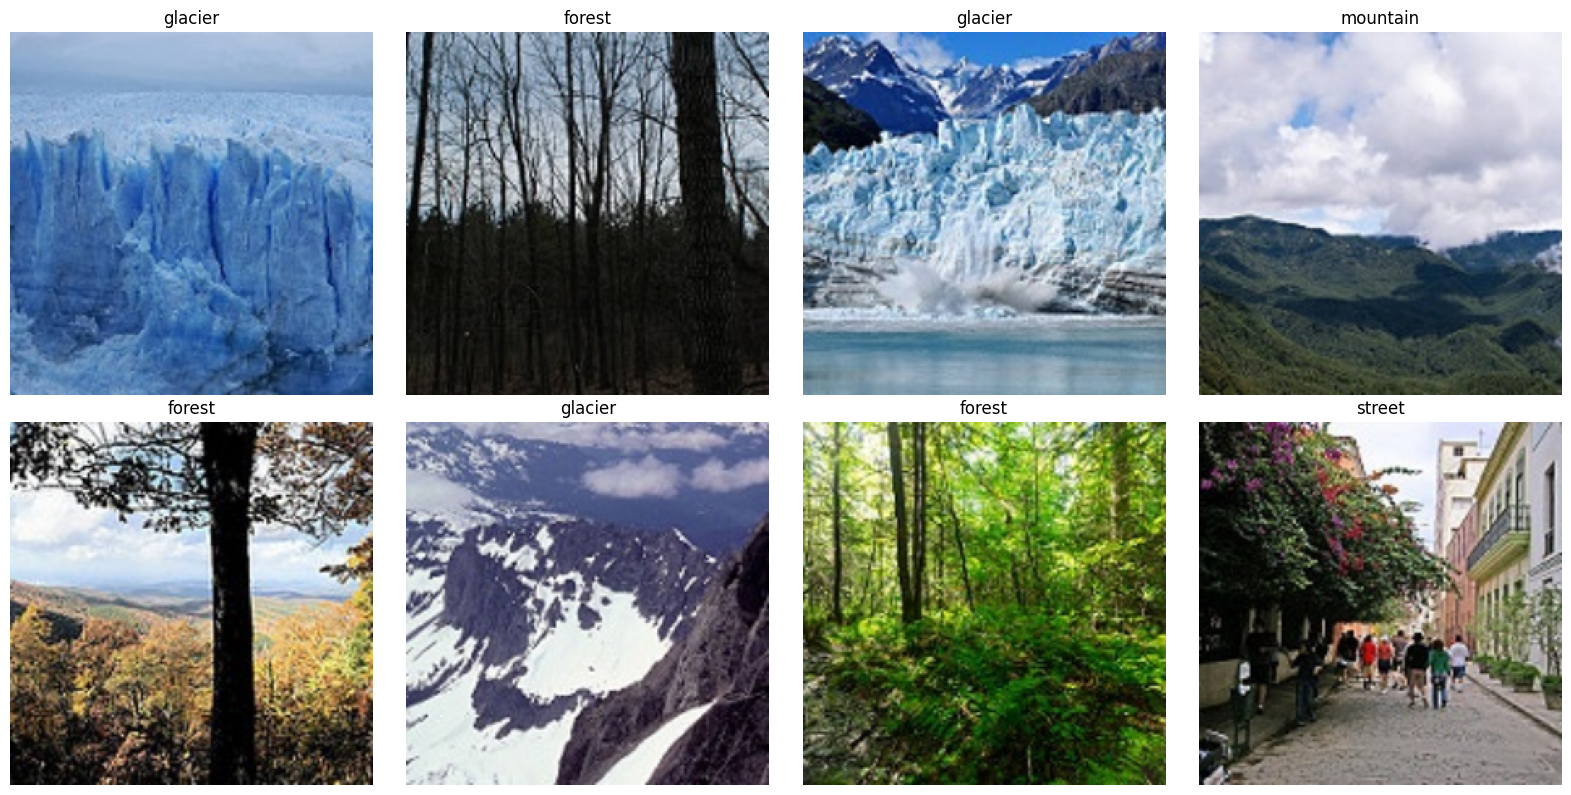

In [ ]:
images, labels = next(iter(train_loader))
visualize_images_with_labels(images, labels, idx_to_class, num_images=8)

## Training


### Weight Initialization


In [ ]:
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

    elif isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
        if module.bias is not None:
            nn.init.zeros_(module.bias)

    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)

### Learning Rate Scheduler


In [ ]:
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # cosine decay
        progress = (current_step - warmup_steps) / float(
            max(1, total_steps - warmup_steps)
        )
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    return LambdaLR(optimizer, lr_lambda)

### Define Training Loop


In [ ]:
def train_step(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size

        avg_loss = total_loss / total
        acc = correct / total
        loop.set_postfix(loss=avg_loss, acc=acc)

    return avg_loss, acc

In [ ]:
def eval_step(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validating", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch_size

            avg_loss = total_loss / total
            acc = correct / total
            loop.set_postfix(loss=avg_loss, acc=acc)

    return avg_loss, acc

### Start Training


In [ ]:
config = ModelConfig()
config.num_classes = len(train_dataset.class_to_idx)
device = get_device()

In [ ]:
vit = ViT(config)
vit.apply(init_weights)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(vit.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, warmup_steps=50, total_steps=1000
)

vit = vit.to(device)

In [ ]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train_step(
        vit, train_loader, criterion, optimizer, scheduler, device
    )
    val_loss, val_acc = eval_step(vit, val_loader, criterion, device)

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/20


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 1.7284, Acc: 0.2675
Val   Loss: 1.5807, Acc: 0.3033
Epoch 2/20


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 1.5226, Acc: 0.3497
Val   Loss: 1.5162, Acc: 0.3183
Epoch 3/20


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 1.4998, Acc: 0.3549
Val   Loss: 1.5364, Acc: 0.3453
Epoch 4/20


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 1.5050, Acc: 0.3582
Val   Loss: 1.4949, Acc: 0.3703
Epoch 5/20


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Train Loss: 1.4806, Acc: 0.3736
Val   Loss: 1.4816, Acc: 0.3853
Epoch 6/20


Training:   0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
def plot_training_curves(
    train_losses, val_losses, train_accuracies, val_accuracies, num_epochs
):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Acc")
    plt.plot(epochs, val_accuracies, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_curves(
    train_losses, val_losses, train_accuracies, val_accuracies, num_epochs
)

In [ ]:
images, labels = next(iter(val_loader))
preds = None
vit.eval()
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    preds = outputs.argmax(dim=1)

    # Move data to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()


visualize_images_with_labels(images, labels, idx_to_class, preds, num_images=8)

## Appendix


In [ ]:
assert False

### Position Interplotation


In [ ]:
config = ModelConfig()
vit = ViT(config)

In [ ]:
orginal_image = torch.randn(8, 3, config.image_size, config.image_size)
original_out = vit(orginal_image)

assert original_out.shape == (8, config.num_classes)

In [ ]:
def interpolate_pos_embed(pretrained_embed, new_grid_size, num_extra_tokens=1):
    cls_token = pretrained_embed[:, :num_extra_tokens]
    patch_pos_embed = pretrained_embed[:, num_extra_tokens:]

    old_size = int(patch_pos_embed.shape[1] ** 0.5)
    patch_pos_embed = patch_pos_embed.reshape(1, old_size, old_size, -1).permute(
        0, 3, 1, 2
    )

    # use bicubic to interpolate
    interpolated = F.interpolate(
        patch_pos_embed, size=new_grid_size, mode="bicubic", align_corners=False
    )

    interpolated = interpolated.permute(0, 2, 3, 1).reshape(
        1, -1, pretrained_embed.shape[-1]
    )

    new_pos_embed = torch.cat((cls_token, interpolated), dim=1)
    return new_pos_embed

In [ ]:
pretrain_pe = vit.positional_encoding.positional_embedding
fine_tune_pe = interpolate_pos_embed(pretrain_pe, 24)

In [ ]:
# Replace the positional encoding weight, and also enable fine tunine
vit.positional_encoding.positional_embedding = nn.Parameter(
    fine_tune_pe, requires_grad=True
)

In [ ]:
fine_tune_image = torch.randn(8, 3, 384, 384)

In [ ]:
# Assume the number of classification is same,
# else, also need to replace the classifcation head(MLP layer)
fine_tune_out = vit(fine_tune_image)
assert fine_tune_out == (8, config.num_classes)

### Visualizing the Image Patch


In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import einops

# # Step 1: Load and resize image to 256x256
# image_path = "github.png"
# img_bgr = cv2.imread(image_path)
# img_resized = cv2.resize(img_bgr, (256, 256), interpolation=cv2.INTER_AREA)
# img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# plt.imshow(img)

In [ ]:
# # Step 2: Patch the image using einops
# patch_size = 16
# patches = einops.rearrange(
#     img, "(h ph) (w pw) c -> (h w) ph pw c", ph=patch_size, pw=patch_size
# )

# # Step 3: Display patches in their original grid layout
# h, w = 256 // patch_size, 256 // patch_size
# fig, axes = plt.subplots(h, w, figsize=(12, 12))
# for i in range(h):
#     for j in range(w):
#         patch_idx = i * w + j
#         axes[i, j].imshow(patches[patch_idx])
#         axes[i, j].axis("off")

# plt.suptitle("Patches shown in original spatial distribution (16x16)", fontsize=16)
# plt.tight_layout()
# plt.show()